## Data
The animal audiograms database contains [44 audiograms](https://animalaudiograms.museumfuernaturkunde.berlin/advanced?order_by=vernacular_name_english&species=698422&taxon=698422&method=&publication=&facility=&from=&to=&medium=water&sex=&liberty=&lifestage=&duration_in_captivity_from=&duration_in_captivity_to=&sedated=&age_from=&age_to=&position=&distance_from=&distance_to=&threshold_from=&threshold_to=&tone=&staircase=&form=&constants=) of harbour seals (*Phoca vitulina* and *P. vitulina vitulina*) in water.

All the audiograms for harbour seals were downloaded and stored in the file `data/Phoca_vitulina_all.csv` 

In [15]:
# import the FFT scripts
source("FFT.R")

In [4]:
# Read the downloaded data
data_file <- "./data/Phoca_vitulina.csv"
audiogram <- read.table(data_file, header=TRUE, sep=",")

## Computing the effective hearing range
The data can now be loaded to estimate the functional hearing range, i.e. the lowest and highest frequency that caused a measurable response in any audiogram of this species.

[1] "lowest frequency in effective hearing range: 0.08 kHz"
[1] "highest frequency in effective hearing range: 100 kHz"


`geom_smooth()` using method = 'loess' and formula 'y ~ x'



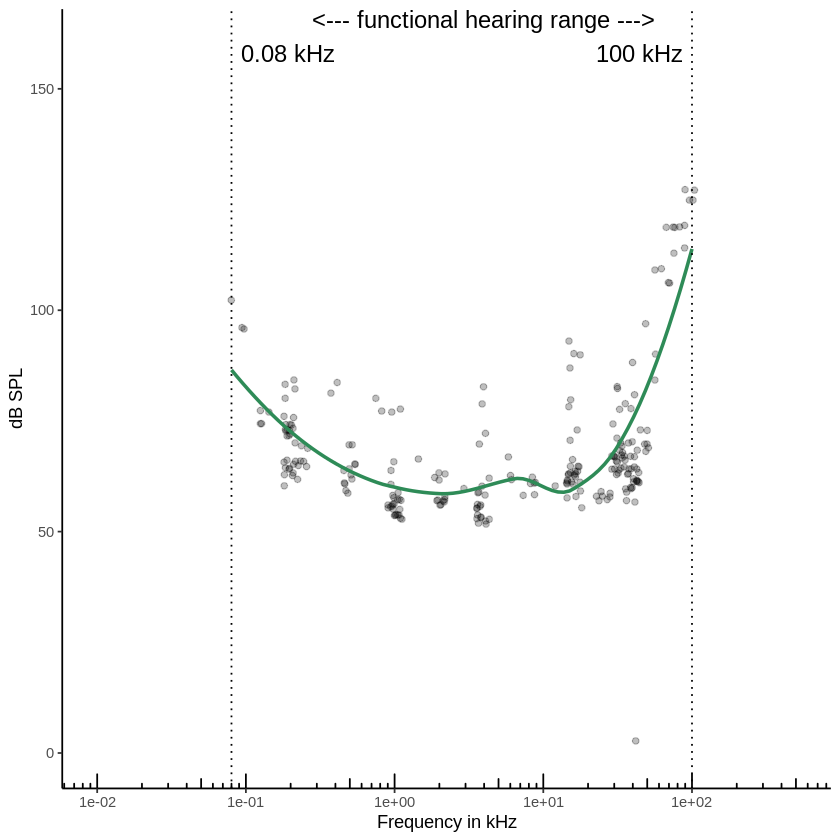

In [16]:
# compute the functional hearing frequency range
range <- def.f.range(audiogram)

print(paste("lowest frequency in effective hearing range:",range$eff.freq.low, "kHz"))
print(paste("highest frequency in effective hearing range:", round(range$eff.freq.high), "kHz"))

# plot the data, the fit curve, and the effective hearing range
plot.effective(audiogram, range)

## Defining the filter values
Filter weights are computed by applying the M-weighting function described in Southall et al. (2007), appendix A, p. 500

Frequency.in.kHz,Gain.in.dB
<dbl>,<dbl>
0.02000000,-56.62899020
0.04397048,-29.18452743
0.09667017,-10.39826308
0.21253171,-2.61496689
0.46725612,-0.54300370
1.02727387,-0.08776015
2.25848647,0.00000000
4.96533715,-0.01916204
10.91641386,-0.20272386


`geom_smooth()` using method = 'loess' and formula 'y ~ x'



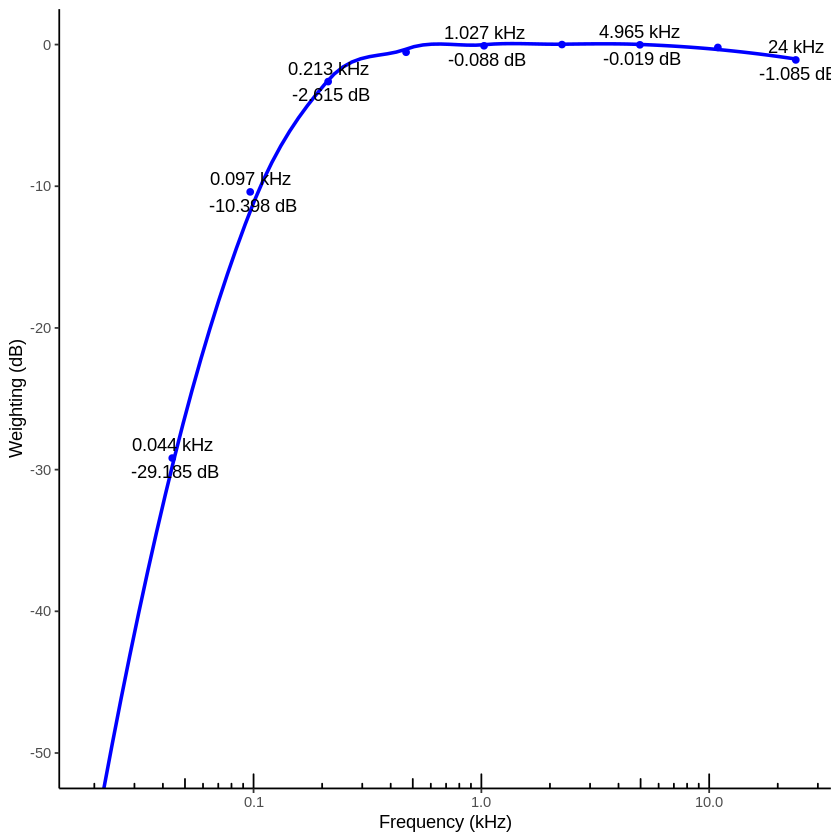

In [17]:
# filter frequencies from 20Hz to 24kHz
seq <- make.f.seq(0.02, 24)

M.table <- make.M.table(seq, range$eff.freq.low, range$eff.freq.high)
M.table

plot.M(M.table, TRUE)

## Implement the filter
Implement a filter using the values from table above. Q is set to 1.414 (1 octave) for a smoother filter curve. The filtered sound is normalized at -3dB.

The generated command can be used to invoque sox by copy-pasting it in a Linux terminal.

In [19]:
# sox command
inputfile <- "data/whitenoise.wav"
outputfile <- "data/M.ft_Phoca_vitulina.wav"
Q <- 1.414
command <- sox_command(inputfile, outputfile, M.table, Q)
command

[1] "sox data/whitenoise.wav data/M.ft_Phoca_vitulina.wav equalizer 20 1.414 -56.6289901955822 equalizer 43.9704839121896 1.414 -29.1845274317251 equalizer 96.6701727736063 1.414 -10.3982630818209 equalizer 212.531713836522 1.414 -2.61496689177728 equalizer 467.256115203944 1.414 -0.543003699735909 equalizer 1027.27387482236 1.414 -0.0877601512466084 equalizer 2258.48646931447 1.414 0 equalizer 4965.33714824449 1.414 -0.0191620362535476 equalizer 10916.4138597741 1.414 -0.202723860542668 norm -3"